# Práctica 1: construyendo un modelo de clasificación de imágenes

En este notebook se muestra cómo crear un modelo de clasificación de imágenes utilizando las técnicas vistas en clase. A lo largo del notebook aparecen una serie de preguntas que debes responder.

Para crear nuestro clasificador de imágenes vamos a utilizar la librería [fastAI](https://www.fast.ai/). Este notebook está inspirado en el curso asociado a dicha librería.

En esta práctica vamos a hacer un uso intensivo de la GPU, así que es importante activar su uso desde la opción Configuración del cuaderno del menú Editar (esta opción debería estar habilitada por defecto, pero es recomendable que lo compruebes).


## Librerías

Comenzamos descargando la última versión de la librería FastAI. Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [1]:
!pip install fastai -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.6 MB/s eta 0:00:00


A continuación, cargamos aquellas librerías que son necesarias.

In [1]:
from fastai.vision.all import *

## Dataset

Para esta práctica vamos a usar como ejemplo de dataset el [Intel Image Classification dataset](https://www.kaggle.com/puneet6060/intel-image-classification). Este dataset consta de imágenes de tamaño 150x150 distribuidas en 6 categorías (buildings, forest, glacier, mountain, sea, street). Los siguientes comandos descargan y descomprimen dicho dataset.

In [2]:
%%capture
!wget https://unirioja-my.sharepoint.com/:u:/g/personal/joheras_unirioja_es/EbMVHqKMSnNHh6I0-4-QWdQBlVDKz2Uz5Ky73zc5tHGofg?download=1 -O IntelImageClassification.zip
!unzip IntelImageClassification.zip

Vamos a explorar el contenido de este dataset. Para ello vamos a crear un objeto [Path](https://docs.python.org/3/library/pathlib.html) que apunta al directorio que acabamos de crear.

In [3]:
path = Path('IntelImageClassification/')

Con el objeto path podemos utilizar funciones como `ls()`.

In [4]:
path.ls()

(#2) [Path('IntelImageClassification/train'),Path('IntelImageClassification/test')]

Vemos que nuestro dataset consta de dos carpetas llamadas `train` y `test`. Recordar que es importante hacer la partición del dataset en dos conjuntos distintos, para luego poder evaluarlo correctamente. Podemos ahora crear objetos `path` que apunten respectivamente a nuestro conjunto de entrenamiento y a nuestro conjunto de test.

In [5]:
trainPath = path/'train'
testPath = path/'test'

Veamos el contenido de cada uno de estos directorios.

In [6]:
trainPath.ls()

(#6) [Path('IntelImageClassification/train/street'),Path('IntelImageClassification/train/sea'),Path('IntelImageClassification/train/mountain'),Path('IntelImageClassification/train/forest'),Path('IntelImageClassification/train/buildings'),Path('IntelImageClassification/train/glacier')]

In [7]:
testPath.ls()

(#6) [Path('IntelImageClassification/test/street'),Path('IntelImageClassification/test/sea'),Path('IntelImageClassification/test/mountain'),Path('IntelImageClassification/test/forest'),Path('IntelImageClassification/test/buildings'),Path('IntelImageClassification/test/glacier')]

Podemos ver que tanto la carpeta `train` como la carpeta `test` contienen 6 subcarpetas, una por cada clase del dataset.

**Ejercicio**

¿Qué contiene la carpeta `buildings` de la carpeta `test`? Ejecuta a continuación el comando necesario para comprobarlo.

In [8]:
ls(testPath/'buildings')

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `ls -F --color (testPath/'buildings')'


## Cargando el dataset

A continuación vamos a mostrar cómo se carga el dataset para poder posteriormente crear nuestro modelo. Este proceso se hace en dos pasos. Primero se construye un objeto `DataBlock` y a continuación se construye un objeto `DataLoader` a partir del `DataBlock`. Tienes más información sobre estos objetos en la documentación de [FastAI](https://docs.fast.ai/tutorial.datablock.html).

### Datablock

Comenzamos construyendo el objeto `DataBlock`. A continuación explicaremos cada una de sus componentes.

In [9]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=[*aug_transforms(size=128,min_scale=0.75),Normalize.from_stats(*imagenet_stats)])

Vamos a ver las distintas componentes del `DataBlock`.

- El atributo `blocks` sirve para indicar el tipo de nuestros datos. Como estamos en un problema de clasificación de imágenes, tenemos que la entrada de nuestro modelo será una imagen, es decir un `ImageBlock`, y la salida será una categoría, es decir un `CategoryBlock`. Por lo tanto indicamos que `blocks = (ImageBlock, CategoryBlock)`.
- El atributo `get_items` debe proporcionar una función para leer los datos. En nuestro caso queremos leer una serie de imágenes que estarán almacenadas en un `path`. Para ello usamos la función `get_image_files`. Puedes ver qué hace exactamente esta función ejecutando el comando `??get_image_files`.
- El atributo `splitter` nos indica cómo partir el dataset. Daros cuenta que tenemos un conjunto de entrenamiento y uno de test, pero para entrenar nuestro modelo y probar distintas alternativas nos interesa usar un conjunto de validación, que lo vamos a tomar de forma aleatorea a partir de nuestro conjunto de entrenamiento usando un 20% del mismo. Para ello usaremos el objeto `RandomSplitter(valid_pct=0.2,seed=42)`.
- El atributo `get_y` sirve para indicar cómo extraemos la clase a partir de nuestros datos. La función `get_image_files` nos proporciona una lista con los paths a las imágenes de nuestro dataset. Si nos fijamos en dichos paths, la clase de cada imagen viene dada por la carpeta en la que está contenida, por lo que podemos usar el método `parent_label` para obtener la clase de la misma.

Por último, los atributos `item_tfms` y `batch_tfms` sirven para aplicar una técnica conocida como *preescalado* (o *presizing*).   



### Preescalado (presizing)

El preescalado es una técnica de aumento de datos diseñada para minimizar la destrucción de datos. Para poder sacar el máximo partido a las GPUs, es necesario que todas las imágenes tengan el mismo tamaño, por lo que es común reescalar todas las imágenes al mismo tamaño.

Sin embargo, hay varias técnicas de aumento que si se aplican después de reescalar pueden introducir zonas vacías o degradar los datos. Por ejemplo, si rotamos una imagen 45 grados, los bordes de la imagen quedan vacíos, lo que no le sirve para nada al modelo. Para solucionar este problema se utiliza la técnica del preescalado que consta de dos pasos.
1. Las imágenes se reescalan a una dimensión mayor que la que se usará realmente para entrenar.
2. Se aplican las distintas técnicas de aumento, y finalmente se reescala al tamaño deseado.

El punto clave es el primer paso que sirve para crear imágenes con el suficiente espacio para luego poder aplicar los distintos aumentos. Tienes más información sobre esta técnica en el [libro de FastAI](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb).

En nuestro caso estamos haciendo un escalado inicial a tamaño 256 para luego aplicar un escalado a tamaño 128. Notar que no sólo estamos aplicando un escalado como técnica de aumento de datos, sino que también gracias a la función `aug_transforms` se aplican otros aumentos.


### Data augmentation

Como hemos visto en clase, la técnica de aumento de datos (o *data augmentation*) nos proporciona un método para aumentar el tamaño de nuestro dataset. FastAI ofrece una serie de aumentos por defecto que se pueden configurar mediante el método `aug_transforms`. Veamos a continuación que aumentos ofrece dicha función.

In [10]:
??aug_transforms

Como vemos la función anterior puede ser utilizada para fijar distintos aumentos y la probabilidad con la que queremos que se apliquen. En caso de querer otro tipo de transformaciones que no estén incluidas por defecto en dicha función podemos usar la librería [Albumentations](https://github.com/albumentations-team/albumentations) como se explica en la documentación de [FastAI](https://docs.fast.ai/tutorial.albumentations.html).

### Dataloader

Pasamos ahora a construir nuestro `DataLoader` que se construye a partir del `DataBlock` construido anteriormente indicándole el path donde se encuentran nuestras imágenes. Además podemos configurar el `DataLoader` indicándole el tamaño del batch que queremos utilizar. Al trabajar con GPUs es importante que usemos batches de tamaño 2^n para optimizar el uso de la GPU.

In [11]:
dls = db.dataloaders(trainPath,bs=128)

A continuación mostramos un batch de nuestro `DataLoader`. Es conveniente comprobar que realmente se han cargado las imágenes y sus anotaciones de manera correcta.

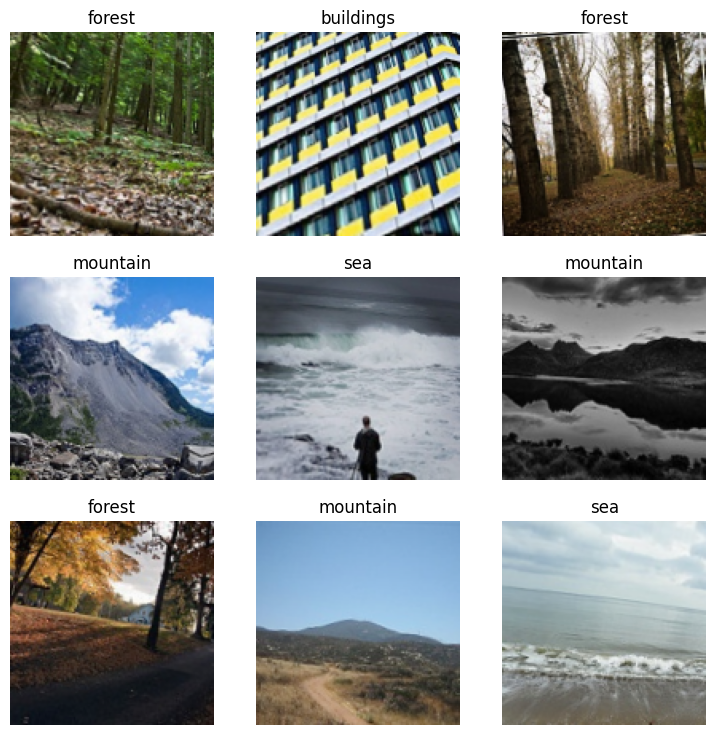

In [12]:
dls.show_batch()

## Entrenando el modelo

Pasamos ahora a construir y entrenar nuestro modelo. Pero antes vamos a definir una serie de *callbacks*.

### Callbacks

En ocasiones nos interesa cambiar el comportamiento por defecto que tiene el proceso de entrenamiento, por ejemplo para guardar los mejores pesos que se han producido hasta ese momento. El procedimiento usado por FastAI para incluir dicha funcionalidad son los *callbacks* que sirven para modificar el proceso de entrenamiento. La lista completa de callbacks incluida en FastAI, está disponible en su [documentación](https://docs.fast.ai/callback.core.html). En nuesto caso sólo vamos a utilizar 3 callbacks:
- ShowGraphCallback: este callback sirve para mostrar las curvas de entrenamiento y validación.
- EarlyStoppingCallback: este callback nos permite aplicar la técnica de early stopping. Para ello debemos indicarle la métrica que queremos monitorizar para saber cuándo parar, y la paciencia (es decir cuántas épocas dejamos que el modelo continúe entrenando si no ha habido mejora).
- SaveModelCallback: este callback guarda el mejor modelo encontrado durante el proceso de entrenamiento y lo carga al final del mismo. Como vamos a crear un modelo usando la arquitectura resnet18 conviene que indiquemos esto en el nombre del modelo. También sería conveniente indicar el nombre del dataset para no confundirlos.

In [13]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='modelResnet18')
]

Además de estos tres callbacks utilizaremos otro que nos servirá para acelerar el entrenamiento de nuestros modelos usando [*mixed precision*](https://docs.fast.ai/callback.fp16.html) - este callback se indica de manera diferente como veremos a continuación.

## Construyendo el modelo

A continuación construimos nuestro modelo, un objeto de la clase `Learner`, utilizando el método `cnn_learner` que toma como parámetros el `DataLoader`, la arquitectura que queremos entrenar (en nuestro caso un `resnet18`), la métrica que usaremos para evaluar nuestro modelo (esta evaluación se hace sobre el conjunto de validación, y en nuestro caso será la *accuracy*), y los callbacks. Notar que en la instrucción anterior incluimos la transformación del modelo a *mixed precision* mediante la instrucción ``to_fp16``.

In [14]:
learn = vision_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


Notar que internamente la función `cnn_learner` hace varias cosas con la arquitectura que le pasamos como parámetro (en este caso `resnet18`). Dicha arquitectura fue entrenada inicialmente para el problema de ImageNet, por lo que ante una nueva imagen, su salida sería la predicción en una de las 1000 clases de ImageNet. Sin embargo, internamente la función `cnn_learner` elimina las últimas capas de dicha arquitectura, y las reemplaza con una adecuada para nuestro problema concreto.

Antes de entrenar nuestro modelo debemos encontrar un *learning rate* adecuado.

### Learning rate finder

Como hemos visto en teoría, el trabajo de [Leslie Smith](https://arxiv.org/abs/1506.01186) proporciona un método para encontrar un learning rate adecuado para entrenar nuestro modelo. Dicho learning rate lo puedes encontrar con la función `lr_find()`.

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0012022644514217973)

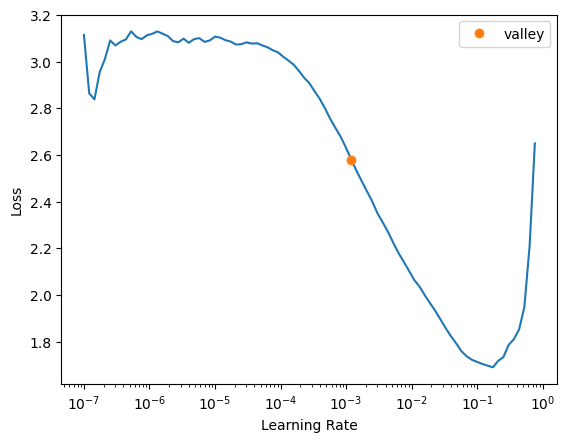

In [15]:
learn.lr_find()

La función anterior no solo nos devuelve un gráfico sino que nos sugiere dos valores `lr_min` y `lr_steep`. La recomendación es utilizar el valor de `lr_steep`, para entrenar el modelo.

### Fine-tuning

A continuación vamos a aplicar la técnica de *fine tuning*. En FastAI esto es tan sencillo como llamar al método `fine_tune` del objeto `Learner`. Este método recibe dos parámetros principalmente, el número de épocas (10 en nuestro caso) y el learning rate. El proceso que sigue para entrenar consiste en:
1. Congelar todas las capas salvo la última, y entrenar esa parte del modelo durante una época.
2. Descongelar la red, y entrenar el modelo por el número de épocas indicado.

Al ejecutar la siguiente instrucción aparecerá una tabla donde podrás ver la pérdida para el conjunto de entrenamiento, la pérdida para el conjunto de validación, y la accuracy para el conjunto de validación.

epoch,train_loss,valid_loss,accuracy,time
0,1.040804,0.404821,0.866358,00:41


Better model found at epoch 0 with valid_loss value: 0.40482112765312195.


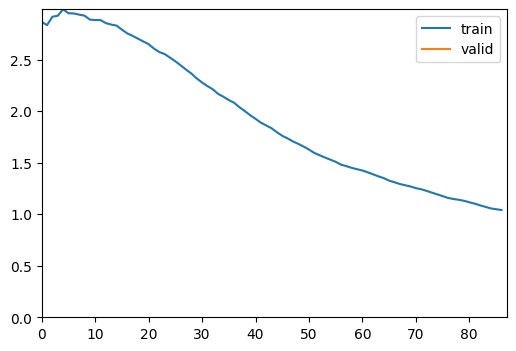

epoch,train_loss,valid_loss,accuracy,time
0,0.526979,0.327774,0.898076,00:39
1,0.437698,0.285320,0.913043,00:39
2,0.343290,0.254205,0.924448,00:39
3,0.282053,0.238116,0.922309,00:40
4,0.231121,0.219584,0.925517,00:41
5,0.187238,0.229749,0.925517,00:41
6,0.165504,0.221776,0.926586,00:39
7,0.137465,0.224632,0.928724,00:40


Better model found at epoch 0 with valid_loss value: 0.3277741074562073.


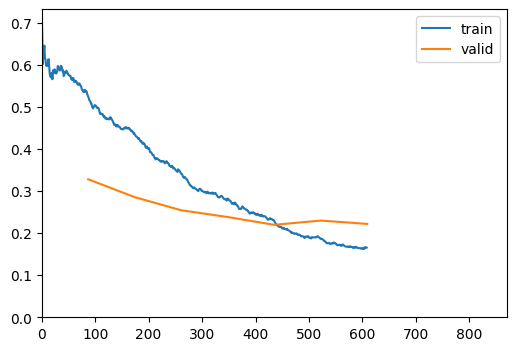

Better model found at epoch 1 with valid_loss value: 0.28531962633132935.
Better model found at epoch 2 with valid_loss value: 0.2542046904563904.
Better model found at epoch 3 with valid_loss value: 0.23811641335487366.
Better model found at epoch 4 with valid_loss value: 0.21958358585834503.
No improvement since epoch 4: early stopping


In [16]:
learn.fine_tune(10,base_lr=1e-3)

Al final del entrenamiento se ha guardado un modelo en la carpeta `models` que contiene el mejor modelo construido.

In [17]:
Path('models').ls()

(#1) [Path('models/modelResnet18.pth')]

Para su uso posterior, es conveniente exportar el modelo. Para ello es necesario en primer lugar convertir el modelo a fp32.

In [18]:
learn.to_fp32()
learn.export()

Podemos ver que dicho modelo se ha guardado en el mismo directorio donde nos encontramos.

In [19]:
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Evaluando el modelo

Una vez tenemos entrenado nuestro modelo nos interesa saber:
1. ¿Qué tal funciona en el conjunto de test?
2. ¿Qué errores comete?
3. ¿Cómo se utiliza para predecir la clase ante nuevas imágenes?




### Evaluando el modelo en el conjunto de test

Para poder evaluar nuestro modelo en el conjunto de test debemos crear un nuevo `DataBlock` y un nuevo `DataLoader`. La única diferencia con el `DataBlock` utilizado previamente es que para hacer la partición del dataset usamos un objeto de la clase `GrandparentSplitter` indicando que el conjunto de validación es nuestro conjunto de test. En el caso del `DataLoader`, la diferencia con el definido anteriormente es que cambiamos la ruta al path.

In [20]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=[*aug_transforms(size=128,min_scale=0.75),Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=128)

Para trabajar con este dataloader debemos modificar nuestro objeto `Learner`. En concreto su atributo `dls`.

In [21]:
learn.dls = dlsTest

Ahora podemos evaluar nuestro modelo usando el método `validate`.

In [22]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9256666898727417.


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

(#2) [0.21035242080688477,0.9256666898727417]

El método `validate` nos devuelve dos valores: el valor de la función de pérdida, y el valor de nuestra métrica (la accuracy en este caso). Por lo que podemos ver que el modelo tiene una accuracy en el conjunto de test de aproximadamente un 82% (esto puede variar dependiendo de la ejecución).

### Interpretación del modelo

Hemos visto que nuestro modelo obtiene una accuracy aproximada (puede variar debido a la aleatoriedad del proceso de entrenamiento) de un 92% en el conjunto de validación. Pero nos interesa conocer los errores que se cometen y si estos son razonables. Para ello podemos construir un objeto `ClassificationInterpretation` a partir de nuestro `Learner` y mostrar la matriz de confusión asociada. Recordar que hemos cambiado el DataLoader en el paso anterior, porque es conveniente volver al dataloader usado inicialmente.

In [23]:
learn.dls=dls

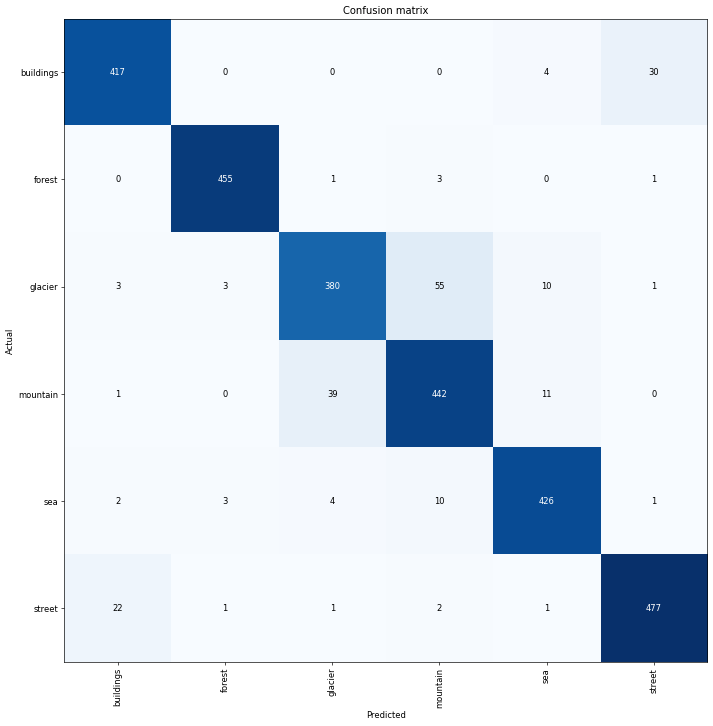

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

Si nos fijamos, la mayoría de errores se producen porque el modelo confunde imágenes de la clase street con imágenes de la clase buildings; e imágenes de la clase mountain con la clase glacier. Podemos ver aquellas en las que se produce un mayor error del siguiente modo. Para ello utilizaremos el comando ``interp.plot_top_losses(10,nrows=2)``.

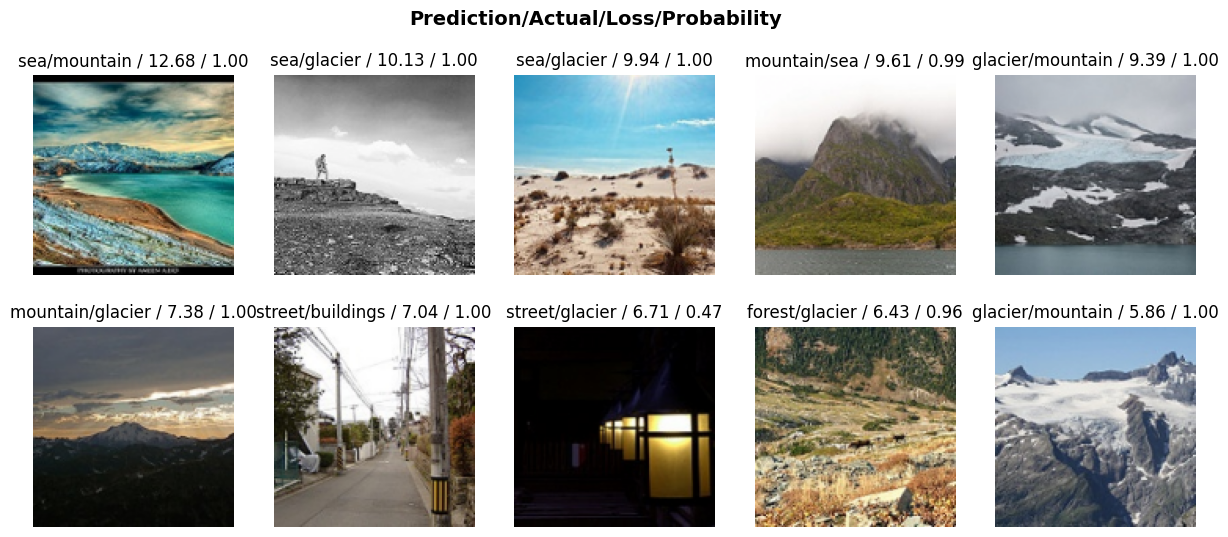

In [25]:
interp.plot_top_losses(10,nrows=2)

A partir de la ejecución anterior, podemos ver que hay algunas imágenes que están mal anotadas, y otras en las que es comprensible por qué se está produciendo el error.

### Usando el modelo

Vamos a ver cómo usar el modelo ante una nueva imagen. Para ello lo primero que vamos a hacer es cargar dicho modelo.

In [26]:
learn_inf = load_learner('export.pkl')

Ahora podemos usar dicho modelo para hacer inferencia con una nueva imagen mediante el método `predict`. En nuestro caso vamos a usar una imagen del conjunto de test.

In [27]:
learn_inf.predict('IntelImageClassification/test/buildings/20057.jpg')

('buildings',
 tensor(0),
 tensor([1.0000e+00, 8.8100e-11, 1.2047e-10, 8.5474e-10, 2.3555e-07, 7.9283e-09]))

La función anterior devuelve tres valores:
- La clase (buildings en este caso).
- El índice asociado a dicha clase.
- Las probabilidades para cada una de las categorías.  

## Creando una aplicación para nuestro modelo

Es fundamental que los modelos sean usables, por lo que es conveniente proporcionar una interfaz secilla que permita usar nuestros modelos. Para ello, vamos a usar dos herramientas: [Gradio](https://gradio.app/) y los [espacios de HuggingFace](https://huggingface.co/spaces). En concreto vamos a ver cómo construir la siguiente [aplicación](https://huggingface.co/spaces/AP2223/Practica1).

En primer lugar es necesario que crees una [cuenta en HuggingFace](https://huggingface.co/join). Este paso sólo hay que realizarlo una vez. Además debes  [crear un token de escritura](https://huggingface.co/docs/hub/security-tokens).

Una vez realizados esos dos pasos vamos a descargar una librería que permita subir nuestro modelo a HuggingFace.

In [28]:
!pip install huggingface_hub["fastai"] -Uq

A continuación nos autenticamos en HuggingFace con el token de escritura creado previamente.

In [29]:
from huggingface_hub import notebook_login

notebook_login()

Finalmente, para subir nuestro modelo debemos indicar nuestro nombre de usuario de HuggingFace y un nombre para nuestro modelo. En la siguiente instrucción cambia joheras por tu nombre de usuario.

In [31]:
from huggingface_hub import push_to_hub_fastai

repo_id = "seayala/seayala"
# repo_id = "magarcd/Practica1"

push_to_hub_fastai(learner=learn, repo_id=repo_id)

model.pkl:   0%|          | 0.00/47.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/seayala/seayala/commit/ef1447b0e8e8a826fe14ea24a17d81cccc3fd7a5', commit_message='Push FastAI model using huggingface_hub.', commit_description='', oid='ef1447b0e8e8a826fe14ea24a17d81cccc3fd7a5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/seayala/seayala', endpoint='https://huggingface.co', repo_type='model', repo_id='seayala/seayala'), pr_revision=None, pr_num=None)

Al ejecutar la celda anterior aparecerá una URL donde podrás encontrar tu modelo. Vamos a ver cómo crear una aplicación con el.

1. Crea un [espacio en HuggingFace](https://huggingface.co/new-space). Al crear dicho espacio usamos como nombre ``Practica1`` y seleccionamos Gradio como SDK.
2. Descarga dos de las imágenes del dataset.
3. Una vez creado el espacio vamos a la pestaña ``Files and versions``. En dicha pestaña debemos:
  - Subir las dos imágenes que hayas descargado mediante el botón Add file -> Upload file.
  - Crear un fichero requirements.txt mediante el botón Add file -> Create a new file. Este [fichero](https://huggingface.co/spaces/AP2223/Practica1/blob/main/requirements.txt) contendrá las librerías que son necesarias instalar para ejecutar nuestra aplicación, en este caso fastai.
  - Crear un fichero app.py mediante el botón Add file -> Create a new file. Este [fichero](https://huggingface.co/spaces/AP2223/Practica1/blob/main/app.py) contendrá el código de la aplicación.
4. Siguiendo estos pasos tendrás una aplicación que podrás ver desde la pestaña ``App`` (la construcción de la aplicación puede llevar unos segundos, el proceso de construcción lo podrás ver pulsando en el botón ``See logs``.
